<a href="https://colab.research.google.com/github/Tepuy-A/Tesis-2/blob/main/Copia_de_Ising_CNN_prueba_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sin validación
GPU


*   Batch size = 64
*   Epoch = 5
*   Opt = SGD + momentum
*   momentum = 0.5
*   learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
*   filters = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]




In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pickle
from urllib.request import urlopen

import matplotlib.pyplot as plt
import time

# Establece semillas
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/'
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

data = pickle.load(urlopen(url_main + data_file_name))
data = np.unpackbits(data).reshape(-1, 1600)
data = data.astype('int')
data[np.where(data == 0)] = -1

labels = pickle.load(urlopen(url_main + label_file_name))
#labels = to_categorical(labels, num_classes=2)

# División de datos
X_ordered = data[:70000, :]
Y_ordered = labels[:70000]

X_critical = data[70000:100000, :]
Y_critical = labels[70000:100000]

X_disordered = data[100000:, :]
Y_disordered = labels[100000:]

del data, labels

# Conjunto de entrenamiento y prueba
X = np.concatenate((X_ordered, X_disordered))
Y = np.concatenate((Y_ordered, Y_disordered))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=42)

# PRIMERA ETAPA

In [3]:
def create_model(filters):
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((40, 40, 1), input_shape=(1600,)),
        tf.keras.layers.Conv2D(filters, (2, 2), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
    ])
    return model

In [4]:
def create_tf_dataset(X, Y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = create_tf_dataset(X_train, Y_train, batch_size=64)
test_dataset = create_tf_dataset(X_test, Y_test, batch_size=64)
critical_dataset = create_tf_dataset(X_critical, Y_critical, batch_size=64)

In [5]:
# Función para evaluar el modelo
def evaluate_model(filters, lr, verbose=True):
    model = create_model(filters)
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Limpiar la sesión de Keras para liberar memoria
    tf.keras.backend.clear_session()

    epoch_times = []  # Lista para almacenar los tiempos de cada época

    start_totaltime = time.time()  # Registrar el tiempo de inicio
    for epoch in range(5):
        start_time = time.time()  # Registrar el tiempo de inicio de la época
        history = model.fit(train_dataset, epochs=1, verbose=verbose)
        epoch_time = time.time() - start_time  # Calcular el tiempo de la época
        epoch_times.append(epoch_time)
        if verbose:
            print(f'Epoch {epoch+1} time: {epoch_time} seconds')

    training_time = time.time() - start_totaltime  # Calcular el tiempo de entrenamiento

    average_epoch_time = sum(epoch_times) / len(epoch_times)  # Calcular el promedio

    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
    critical_loss, critical_accuracy = model.evaluate(critical_dataset, verbose=0)

    return train_loss, train_accuracy, test_loss, test_accuracy, critical_loss, critical_accuracy, average_epoch_time, training_time


In [11]:
# Función de búsqueda en cuadrícula
def grid_search(verbose=True):
    filters = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]

    results_1 = {}

    for f in filters:
        for lr in learning_rates:
            print(f'Training CNN with {f} filters and SGD lr={lr}')

            train_loss_1, train_accuracy_1, test_loss_1, test_accuracy_1, critical_loss_1, critical_accuracy_1, average_epoch_time_1, training_time_1 = evaluate_model(f, lr, verbose)
            results_1[(f, lr)] = {
                'train_loss': train_loss_1,
                'train_accuracy': train_accuracy_1,
                'test_loss': test_loss_1,
                'test_accuracy': test_accuracy_1,
                'critical_loss': critical_loss_1,
                'critical_accuracy': critical_accuracy_1,
                'average_epoch_time': average_epoch_time_1,
                'training_time': training_time_1

            }

    return results_1

In [12]:
# Ejecutar grid_search y guardar los resultados
results_1 = grid_search()

Training CNN with 1 filters and SGD lr=0.0001
1625/1625 [==============================] - 5s 3ms/step - loss: 0.1910 - accuracy: 0.9075
Epoch 1 time: 4.888481855392456 seconds
1625/1625 [==============================] - 4s 3ms/step - loss: 0.0157 - accuracy: 0.9972
Epoch 2 time: 4.280071020126343 seconds
1625/1625 [==============================] - 4s 3ms/step - loss: 0.0080 - accuracy: 0.9989
Epoch 3 time: 4.258329153060913 seconds
1625/1625 [==============================] - 5s 3ms/step - loss: 0.0054 - accuracy: 0.9993
Epoch 4 time: 4.51269006729126 seconds
1625/1625 [==============================] - 4s 3ms/step - loss: 0.0040 - accuracy: 0.9997
Epoch 5 time: 4.427701711654663 seconds
Training CNN with 1 filters and SGD lr=0.001
1625/1625 [==============================] - 5s 3ms/step - loss: 0.0238 - accuracy: 0.9900
Epoch 1 time: 4.925872325897217 seconds
1625/1625 [==============================] - 4s 3ms/step - loss: 0.0013 - accuracy: 0.9999
Epoch 2 time: 4.189803123474121 s

In [17]:
def extract_data(results, metric):
    filters = sorted(set(key[0] for key in results.keys()))
    learning_rates = sorted(set(key[1] for key in results.keys()))
    data_matrix = np.zeros((len(filters), len(learning_rates)))

    for i, f in enumerate(filters):
        for j, lr in enumerate(learning_rates):
            data_matrix[i, j] = results[(f, lr)][metric]

    return learning_rates, filters, data_matrix

In [78]:
def plot_data(x, y, data, title=None):
    fontsize = 12

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', aspect=0.4)

    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel(title, rotation=90, fontsize=fontsize)

    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = f"{data[j, i]:.2f}"
            ax.text(x_val, y_val, c, va='center', ha='center')

    # Convert elements of x to strings individually
    x_labels = [str(i) for i in x]
    y_labels = [str(i) for i in y]

    ax.set_xticks(np.arange(len(x)), labels=x_labels) # Use the list of string labels
    ax.set_yticks(np.arange(len(y)), labels=y_labels)



    ax.set_xlabel('Tasa de aprendizaje', fontsize=fontsize)
    ax.set_ylabel('Filtros', fontsize=fontsize)
    if title is not None:
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

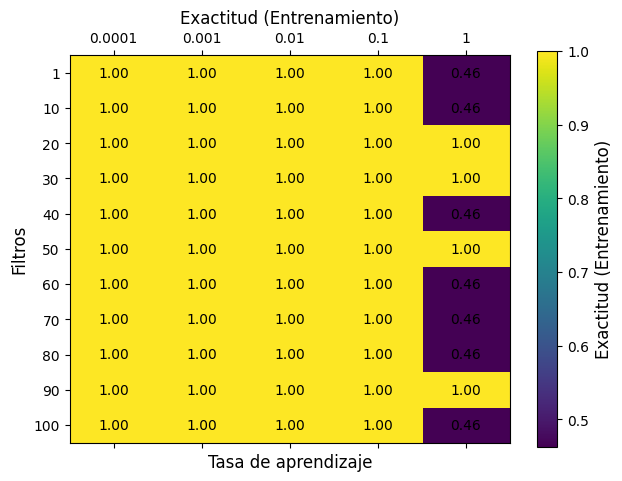

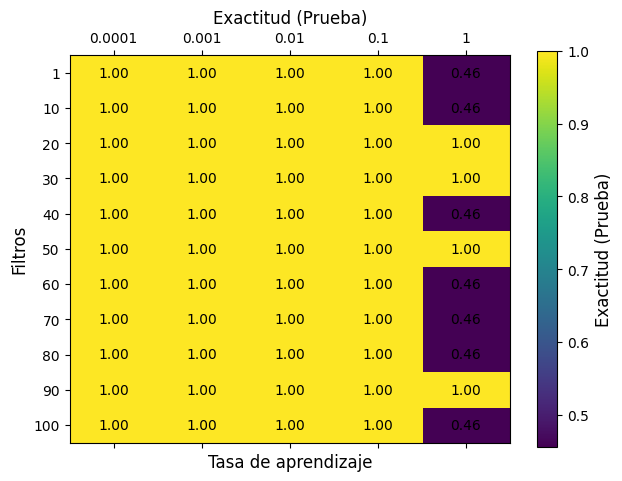

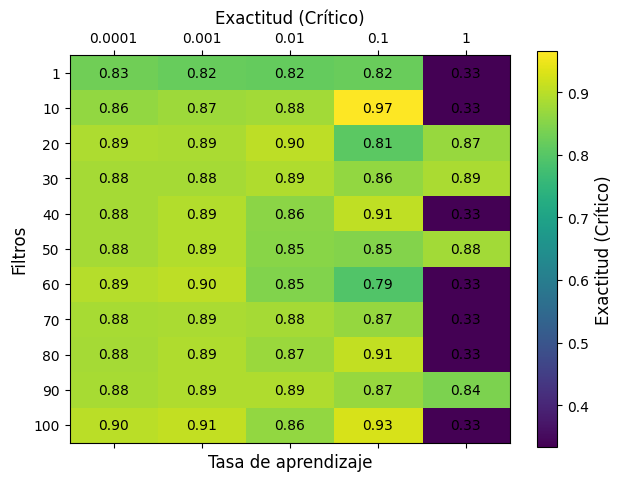

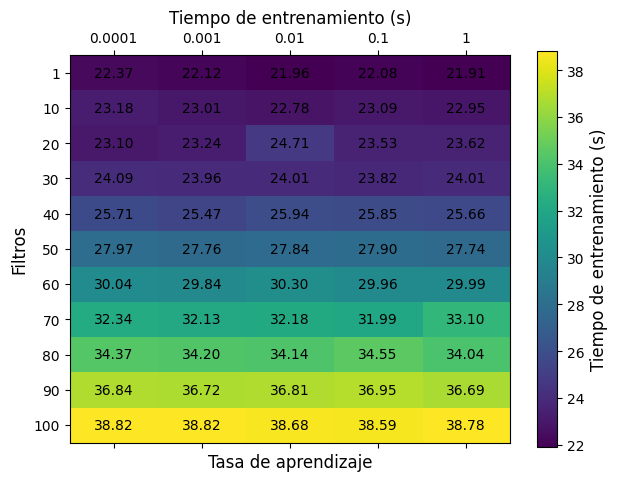

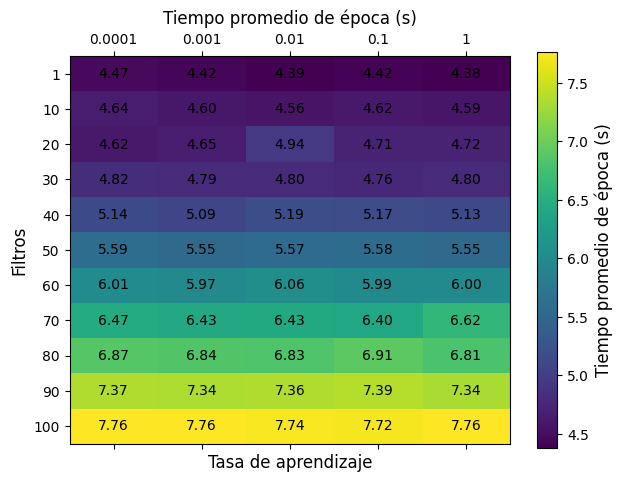

In [79]:
# Graficar los resultados para cada métrica
for metric in ['train_accuracy', 'test_accuracy', 'critical_accuracy']:
    learning_rates, filters, data_matrix = extract_data(results_1, metric)

    # Cambiar los títulos de los gráficos
    if metric == 'train_accuracy':
        title = 'Exactitud (Entrenamiento)'
    elif metric == 'test_accuracy':
        title = 'Exactitud (Prueba)'
    elif metric == 'critical_accuracy':
        title = 'Exactitud (Crítico)'


    plot_data(learning_rates, filters, data_matrix, title=title)



# Graficar el tiempo de entrenamiento
learning_rates, filters, training_time_matrix = extract_data(results_1, 'training_time')
plot_data(learning_rates, filters, training_time_matrix, title='Tiempo de entrenamiento (s)')


# Graficar el tiempo promedio de epoca
learning_rates, filters, average_epoch_time_matrix = extract_data(results_1, 'average_epoch_time')
plot_data(learning_rates, filters, average_epoch_time_matrix, title='Tiempo promedio de época (s)')

In [22]:
import psutil
import os
import resource

def get_memory_usage():
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    return {
        'rss': memory_info.rss,  # Resident Set Size
        'vms': memory_info.vms,  # Virtual Memory Size
        'shared': memory_info.shared,
        'text': memory_info.text,
        'lib': memory_info.lib,
        'data': memory_info.data,
        'dirty': memory_info.dirty
    }

def get_disk_usage():
    disk_usage = psutil.disk_usage('/')
    return {
        'total': disk_usage.total,
        'used': disk_usage.used,
        'free': disk_usage.free,
        'percent': disk_usage.percent
    }

def get_cpu_usage():
    cpu_usage = psutil.cpu_percent(interval=1)
    return {
        'cpu_percent': cpu_usage
    }

def get_resource_usage():
    resource_usage = resource.getrusage(resource.RUSAGE_SELF)
    return {
        'utime': resource_usage.ru_utime,  # User CPU time used
        'stime': resource_usage.ru_stime,  # System CPU time used
        'maxrss': resource_usage.ru_maxrss,  # Maximum resident set size
        'ixrss': resource_usage.ru_ixrss,   # Integral shared memory size
        'idrss': resource_usage.ru_idrss,   # Integral unshared data size
        'isrss': resource_usage.ru_isrss,   # Integral unshared stack size
        'minflt': resource_usage.ru_minflt, # Page reclaims (soft page faults)
        'majflt': resource_usage.ru_majflt, # Page faults (hard page faults)
        'nswap': resource_usage.ru_nswap,   # Number of swaps
        'inblock': resource_usage.ru_inblock,  # Block input operations
        'oublock': resource_usage.ru_oublock,  # Block output operations
        'msgsnd': resource_usage.ru_msgsnd,  # IPC messages sent
        'msgrcv': resource_usage.ru_msgrcv,  # IPC messages received
        'nsignals': resource_usage.ru_nsignals, # Signals received
        'nvcsw': resource_usage.ru_nvcsw,    # Voluntary context switches
        'nivcsw': resource_usage.ru_nivcsw   # Involuntary context switches
    }

print("Memory Usage:", get_memory_usage())
print("Disk Usage:", get_disk_usage())
print("CPU Usage:", get_cpu_usage())
print("Resource Usage:", get_resource_usage())


Memory Usage: {'rss': 10817650688, 'vms': 27327946752, 'shared': 644042752, 'text': 2818048, 'lib': 0, 'data': 11686719488, 'dirty': 0}
Disk Usage: {'total': 216063848448, 'used': 29354831872, 'free': 186692239360, 'percent': 13.6}
CPU Usage: {'cpu_percent': 1.0}
Resource Usage: {'utime': 4480.330285, 'stime': 314.490417, 'maxrss': 10564376, 'ixrss': 0, 'idrss': 0, 'isrss': 0, 'minflt': 2479105, 'majflt': 3066, 'nswap': 0, 'inblock': 448584, 'oublock': 512, 'msgsnd': 0, 'msgrcv': 0, 'nsignals': 0, 'nvcsw': 48811286, 'nivcsw': 123057}


In [23]:
print(results_1)


{(1, 0.0001): {'train_loss': 0.002238380489870906, 'train_accuracy': 0.9998942017555237, 'test_loss': 0.002150881802663207, 'test_accuracy': 0.9998461604118347, 'critical_loss': 0.40079763531684875, 'critical_accuracy': 0.8291333317756653, 'average_epoch_time': 4.473454761505127, 'training_time': 22.36764144897461}, (1, 0.001): {'train_loss': 0.0001501345686847344, 'train_accuracy': 0.9999904036521912, 'test_loss': 0.0001428839605068788, 'test_accuracy': 1.0, 'critical_loss': 0.455747127532959, 'critical_accuracy': 0.8184333443641663, 'average_epoch_time': 4.423289585113525, 'training_time': 22.117149114608765}, (1, 0.01): {'train_loss': 7.143314633140108e-06, 'train_accuracy': 1.0, 'test_loss': 6.620548447244801e-06, 'test_accuracy': 1.0, 'critical_loss': 0.5124486684799194, 'critical_accuracy': 0.8165666460990906, 'average_epoch_time': 4.391847896575928, 'training_time': 21.959571838378906}, (1, 0.1): {'train_loss': 6.198917645861002e-08, 'train_accuracy': 1.0, 'test_loss': 5.6977278

In [29]:
# Encontrar el mejor resultado para cada conjunto de datos,
# utilizando la función max y una función lambda para especificar
# la métrica de comparación (accuracy).
best_train_result = max(results_1.items(), key=lambda item: item[1]['train_accuracy'])
best_test_result = max(results_1.items(), key=lambda item: item[1]['test_accuracy'])
best_critical_result = max(results_1.items(), key=lambda item: item[1]['critical_accuracy'])

# Imprimir los mejores resultados para cada conjunto de datos.
print("Mejor resultado para train:", best_train_result)
print("Mejor resultado para test:", best_test_result)
print("Mejor resultado para critical:", best_critical_result)

best_train_accuracy = best_train_result[1]['train_accuracy']
best_test_accuracy = best_test_result[1]['test_accuracy']
best_critical_accuracy = best_critical_result[1]['critical_accuracy']

# Extraer los valores de 'filters' y 'lr' de los mejores resultados.
best_train_filters, best_train_lr = best_train_result[0]
best_test_filters, best_test_lr = best_test_result[0]
best_critical_filters, best_critical_lr = best_critical_result[0]

# Imprimir los mejores hiperparámetros (filters y lr) para cada conjunto de datos.
print("Mejor exactitud (entrenamiento) =", best_train_accuracy,"con hiperparámetros: número de filtros =", best_train_filters, "y lr =", best_train_lr)
print("Mejor exactitud (prueba) =", best_test_accuracy,"con hiperparámetros: número de filtros =", best_test_filters, "y lr =", best_test_lr)
print("Mejor exactitud (critico) =", best_critical_accuracy,"con hiperparámetros: número de filtros =", best_critical_filters, "y lr =", best_critical_lr)

Mejor resultado para train: ((1, 0.01), {'train_loss': 7.143314633140108e-06, 'train_accuracy': 1.0, 'test_loss': 6.620548447244801e-06, 'test_accuracy': 1.0, 'critical_loss': 0.5124486684799194, 'critical_accuracy': 0.8165666460990906, 'average_epoch_time': 4.391847896575928, 'training_time': 21.959571838378906})
Mejor resultado para test: ((1, 0.001), {'train_loss': 0.0001501345686847344, 'train_accuracy': 0.9999904036521912, 'test_loss': 0.0001428839605068788, 'test_accuracy': 1.0, 'critical_loss': 0.455747127532959, 'critical_accuracy': 0.8184333443641663, 'average_epoch_time': 4.423289585113525, 'training_time': 22.117149114608765})
Mejor resultado para critical: ((10, 0.1), {'train_loss': 0.0, 'train_accuracy': 1.0, 'test_loss': 0.0, 'test_accuracy': 1.0, 'critical_loss': 456.0407409667969, 'critical_accuracy': 0.9663333296775818, 'average_epoch_time': 4.61686520576477, 'training_time': 23.08506464958191})
Mejor exactitud (entrenamiento) = 1.0 con hiperparámetros: número de filtr

Resultados importantes para comparar

In [55]:
def calcular_sobreajuste(train_accuracy, test_accuracy):
  """Calcula el porcentaje de sobreajuste.

  Args:
    train_accuracy: Precisión en los datos de entrenamiento.
    test_accuracy: Precisión en los datos de prueba o críticos.

  Returns:
    El porcentaje de sobreajuste.
  """
  overfitting = (train_accuracy - test_accuracy) / train_accuracy * 100
  return overfitting

In [81]:
train_accuracy_for_chosen_params = results_1[(10, 0.1)]['train_accuracy']
test_accuracy_for_chosen_params = results_1[(10, 0.1)]['test_accuracy']
critical_accuracy_for_chosen_params = results_1[(10, 0.1)]['critical_accuracy']
training_time_for_chosen_params = results_1[(10, 0.1)]['training_time']

print(f'Tiempo de entrenamiento para mejor modelo: {training_time_for_chosen_params} segundos')
print('Exactitud (entrenamiento) =', train_accuracy_for_chosen_params )
print('Exactitud (prueba) =', test_accuracy_for_chosen_params )
print('Exactitud (crítico) =', critical_accuracy_for_chosen_params)

sobreajuste_test = calcular_sobreajuste(train_accuracy_for_chosen_params, test_accuracy_for_chosen_params)
sobreajuste_critico = calcular_sobreajuste(train_accuracy_for_chosen_params, critical_accuracy_for_chosen_params)

print(f"Porcentaje de sobreajuste (prueba): {sobreajuste_test:.2f}%")
print(f"Porcentaje de sobreajuste (crítico): {sobreajuste_critico:.2f}%")

Tiempo de entrenamiento para mejor modelo: 23.08506464958191 segundos
Exactitud (entrenamiento) = 1.0
Exactitud (prueba) = 1.0
Exactitud (crítico) = 0.9663333296775818
Porcentaje de sobreajuste (prueba): 0.00%
Porcentaje de sobreajuste (crítico): 3.37%


In [30]:
train_accuracy_for_chosen_params = results_1[(10, 0.1)]['train_accuracy']
test_accuracy_for_chosen_params = results_1[(10, 0.1)]['test_accuracy']

print("Mejor exactitud (entrenamiento) =", best_train_accuracy,"con hiperparámetros: número de filtros =", best_train_filters, "y lr =", best_train_lr)
print("exactitud (prueba) =", test_accuracy_for_chosen_params,"con hiperparámetros: número de filtros =", best_train_filters, "y lr =", best_train_lr)
print("Mejor exactitud (critico) =", best_critical_accuracy,"con hiperparámetros: número de filtros =", best_critical_filters, "y lr =", best_critical_lr)

Mejor exactitud (entrenamiento) = 1.0 con hiperparámetros: número de filtros = 1 y lr = 0.01
exactitud (prueba) = 1.0 con hiperparámetros: número de filtros = 1 y lr = 0.01
Mejor exactitud (critico) = 0.9663333296775818 con hiperparámetros: número de filtros = 10 y lr = 0.1


In [32]:
chosen_filters = best_critical_filters
chosen_lr = best_critical_lr

# SEGUNDA ETAPA

In [35]:
# Define una función para construir el modelo

from tensorflow.keras import regularizers

def create_model_2(filters, lmbda):
    model = tf.keras.Sequential([
        # Redimensiona la entrada a una imagen 2D de 40x40 con un canal
        tf.keras.layers.Reshape((40, 40, 1),
                                input_shape=(1600,)),
        # Capa convolucional con filtros, kernel 2x2, padding 'same' y activación ReLU. Aplica regularización L2.
        tf.keras.layers.Conv2D(filters, (2, 2),
                               padding='same',
                               activation='relu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42),
                               kernel_regularizer=tf.keras.regularizers.l2(lmbda)),
        tf.keras.layers.MaxPooling2D((2, 2)), # Capa de Max Pooling con tamaño de ventana 2x2
        tf.keras.layers.BatchNormalization(), # Capa de normalización por lotes para mejorar la estabilidad y la velocidad del entrenamiento
        tf.keras.layers.Flatten(), # Aplana la salida de la capa anterior en un vector 1D
        tf.keras.layers.Dense(2,
                              activation='softmax',
                              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)) # Capa densa de salida con 2 neuronas (para clasificación binaria) y activación softmax
    ])

    return model

In [36]:
# Función para evaluar el modelo
def evaluate_model_2(filters, lr, lmbda, verbose=True):
    model = create_model_2(filters, lmbda) # Crea el modelo CNN

    # Compila el modelo con optimizador SGD, tasa de aprendizaje lr y momentum 0.5
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.5),
                  loss='sparse_categorical_crossentropy', # Función de pérdida para clasificación multiclase con etiquetas enteras
                  metrics=['accuracy']) # Métrica para evaluar el rendimiento del modelo

    # Limpiar la sesión de Keras para liberar memoria
    tf.keras.backend.clear_session()

    epoch_times = []  # Lista para almacenar los tiempos de cada época

    start_totaltime = time.time()  # Registra el tiempo de inicio del entrenamiento
    for epoch in range(5): # Itera sobre las épocas
        start_time = time.time()  # Registrar el tiempo de inicio de la época
        history = model.fit(train_dataset, epochs=1, verbose=verbose) # Entrena el modelo por una época
        epoch_time = time.time() - start_time  # Calcular el tiempo de la época
        epoch_times.append(epoch_time) # Agrega el tiempo de la época a la lista
        if verbose:
            print(f'Epoch {epoch+1} time: {epoch_time} seconds')

    training_time = time.time() - start_totaltime  # Calcular el tiempo de entrenamiento

    average_epoch_time = sum(epoch_times) / len(epoch_times)  # Calcula el tiempo promedio por época

    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0) # Evalúa el modelo en el conjunto de entrenamiento
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0) # Evalúa el modelo en el conjunto de prueba

    return train_loss, train_accuracy, test_loss, test_accuracy, average_epoch_time, training_time  # Devuelve las métricas


In [40]:
# Función de búsqueda en cuadrícula
def lambda_search(verbose=True):
    filters = chosen_filters
    learning_rate = chosen_lr
    lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+00, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]

    results_2 = {}

    for lmbda in lambdas:
            print(f'Training CNN with lambda = {lmbda}')

            train_loss, train_accuracy, test_loss, test_accuracy, average_epoch_time, training_time = evaluate_model_2(filters, learning_rate, lmbda, verbose)
            results_2[lmbda] = {
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy,
                'average_epoch_time': average_epoch_time,  # Agregar el tiempo promedio de época
                'training_time': training_time  # Agregar el tiempo de entrenamiento

            }

    return results_2

In [41]:
# Ejecutar grid_search y guardar los resultados
results_2 = lambda_search()

Training CNN with lambda = 1e-05
1625/1625 [==============================] - 5s 3ms/step - loss: 0.1079 - accuracy: 0.9984
Epoch 1 time: 5.076457738876343 seconds
1625/1625 [==============================] - 5s 3ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 2 time: 4.58824896812439 seconds
1625/1625 [==============================] - 5s 3ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 3 time: 4.516540288925171 seconds
1625/1625 [==============================] - 5s 3ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 4 time: 4.5612242221832275 seconds
1625/1625 [==============================] - 5s 3ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 5 time: 4.546088218688965 seconds
Training CNN with lambda = 0.0001
1625/1625 [==============================] - 5s 3ms/step - loss: 0.4746 - accuracy: 0.9955
Epoch 1 time: 5.164637804031372 seconds
1625/1625 [==============================] - 5s 3ms/step - loss: 0.0636 - accuracy: 1.0000
Epoch 2 time: 4.636709451675415 seconds
1625/1625 [=====

In [42]:
print(results_2)

{1e-05: {'train_loss': 0.002779285190626979, 'train_accuracy': 1.0, 'test_loss': 0.002779295202344656, 'test_accuracy': 1.0, 'average_epoch_time': 4.6577118873596195, 'training_time': 23.289334535598755}, 0.0001: {'train_loss': 0.04034014418721199, 'train_accuracy': 1.0, 'test_loss': 0.04033966362476349, 'test_accuracy': 1.0, 'average_epoch_time': 4.684957361221313, 'training_time': 23.425090312957764}, 0.001: {'train_loss': 59.84444808959961, 'train_accuracy': 0.9993076920509338, 'test_loss': 60.53263854980469, 'test_accuracy': 0.9991922974586487, 'average_epoch_time': 4.642572593688965, 'training_time': 23.21321129798889}, 0.01: {'train_loss': 0.6904187798500061, 'train_accuracy': 0.537086546421051, 'test_loss': 0.6893004179000854, 'test_accuracy': 0.5439615249633789, 'average_epoch_time': 4.724383878707886, 'training_time': 23.622269868850708}, 0.1: {'train_loss': 0.6904614567756653, 'train_accuracy': 0.537086546421051, 'test_loss': 0.6892794370651245, 'test_accuracy': 0.54396152496

In [43]:
# Extrae los resultados para graficar
train_accuracy_2 = [results_2[lmbda]['train_accuracy'] for lmbda in results_2]
test_accuracy_2 = [results_2[lmbda]['test_accuracy'] for lmbda in results_2]
training_time_2 = [results_2[lmbda]['training_time'] for lmbda in results_2]
average_epoch_time_2 = [results_2[lmbda]['average_epoch_time'] for lmbda in results_2]
lambdas = list(results_2.keys())

In [44]:
print(train_accuracy_2)
print(test_accuracy_2)

[1.0, 1.0, 0.9993076920509338, 0.537086546421051, 0.537086546421051, 0.537086546421051, 0.537086546421051, 0.462913453578949, 0.462913453578949, 0.462913453578949, 0.462913453578949]
[1.0, 1.0, 0.9991922974586487, 0.5439615249633789, 0.5439615249633789, 0.5439615249633789, 0.5439615249633789, 0.4560384750366211, 0.4560384750366211, 0.4560384750366211, 0.4560384750366211]


In [45]:
best_train_index_2 = np.argmax(train_accuracy_2)
best_test_index_2 = np.argmax(test_accuracy_2)

best_lambda_train = lambdas[best_train_index_2]
best_lambda_test = lambdas[best_test_index_2]

best_train_accuracy = train_accuracy_2[best_train_index_2]
best_training_time = training_time_2[best_train_index_2]
best_avg_epoch_time = average_epoch_time_2[best_train_index_2]
best_test_accuracy = test_accuracy_2[best_test_index_2]



print(f"Mejor exactitud (entrenamiento) = {train_accuracy_2[best_train_index_2]}, con lambda = {best_lambda_train}, tiempo de entrenamiento = {best_training_time}")
print(f"Mejor exactitud (prueba) = {test_accuracy_2[best_test_index_2]}, con lambda =  {best_lambda_test}")

Mejor exactitud (entrenamiento) = 1.0, con lambda = 1e-05, tiempo de entrenamiento = 23.289334535598755
Mejor exactitud (prueba) = 1.0, con lambda =  1e-05


In [46]:
chosen_lambda = best_lambda_train

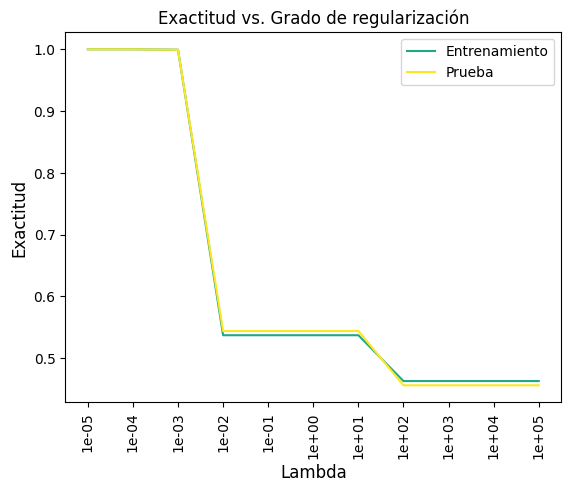

In [80]:
import matplotlib.pyplot as plt

plt.xscale('log')  # Establece la escala logarítmica en el eje x
plt.xticks(lambdas, [f'{lmbda:.0e}' for lmbda in lambdas])  # Formatea las etiquetas de los ticks
plt.xticks(rotation=90)
plt.plot(lambdas, train_accuracy_2,'#21a784', label='Entrenamiento')
plt.plot(lambdas, test_accuracy_2,'#fde624', label='Prueba')
plt.xlabel('Lambda', fontsize = 12)
plt.ylabel('Exactitud', fontsize = 12)
plt.title('Exactitud vs. Grado de regularización')
plt.legend()
plt.show()

# MEJOR MODELO

In [48]:
# Crea el modelo con el mejor lambda

best_model = create_model_2(filters=chosen_filters, lmbda=chosen_lambda)

# Compila el modelo
best_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=chosen_lr, momentum=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Ajusta el modelo con los datos de entrenamiento
start_time_best = time.time()
best_model.fit(train_dataset, epochs=5)
training_time_best = time.time() - start_time_best

Epoch 1/5
1625/1625 [==============================] - 5s 3ms/step - loss: 0.1530 - accuracy: 0.9969
Epoch 2/5
1625/1625 [==============================] - 5s 3ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 3/5
1625/1625 [==============================] - 5s 3ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 4/5
1625/1625 [==============================] - 5s 3ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 5/5
1625/1625 [==============================] - 5s 3ms/step - loss: 0.0016 - accuracy: 1.0000


In [53]:
# Evaluar el modelo en el conjunto de entrenamiento
train_loss_bestmodel, train_accuracy_bestmodel = best_model.evaluate(X_train, Y_train, verbose=0)

# Evaluar el modelo en el conjunto de prueba
test_loss_bestmodel, test_accuracy_bestmodel = best_model.evaluate(X_test, Y_test, verbose=0)

# Evaluar el modelo en el conjunto crítico
critical_loss_bestmodel, critical_accuracy_bestmodel = best_model.evaluate(X_critical, Y_critical, verbose=0)

In [54]:
print(f'Tiempo de entrenamiento para best_model: {training_time_best} segundos')
print('Exactitud (entrenamiento) =', train_accuracy_bestmodel )
print('Exactitud (prueba) =', test_accuracy_bestmodel )
print('Exactitud (crítico) =', critical_accuracy_bestmodel)

Tiempo de entrenamiento para best_model: 23.412046909332275 segundos
Exactitud (entrenamiento) = 1.0
Exactitud (prueba) = 1.0
Exactitud (crítico) = 0.8865333199501038


In [56]:
sobreajuste_test = calcular_sobreajuste(train_accuracy_bestmodel, test_accuracy_bestmodel)
sobreajuste_critico = calcular_sobreajuste(train_accuracy_bestmodel, critical_accuracy_bestmodel)

print(f"Porcentaje de sobreajuste (prueba): {sobreajuste_test:.2f}%")
print(f"Porcentaje de sobreajuste (crítico): {sobreajuste_critico:.2f}%")

Porcentaje de sobreajuste (prueba): 0.00%
Porcentaje de sobreajuste (crítico): 11.35%


# PRUEBA ADICIONAL AUMENTAR ÉPOCAS

In [ ]:
# Crea el modelo con el mejor lambda

best_model_2 = create_model_2(filters=chosen_filters, lmbda=chosen_lambda)

# Compila el modelo
best_model_2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=chosen_lr, momentum=0.5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [106]:
# Ajusta el modelo con los datos de entrenamiento
start_time_best_2 = time.time()
best_model_2.fit(train_dataset, epochs=50)
training_time_best_2 = time.time() - start_time_best_2

Epoch 1/50
1625/1625 [==============================] - 5s 3ms/step - loss: 11.4321 - accuracy: 1.0000
Epoch 2/50
1625/1625 [==============================] - 5s 3ms/step - loss: 11.2845 - accuracy: 1.0000
Epoch 3/50
1625/1625 [==============================] - 5s 3ms/step - loss: 11.1383 - accuracy: 1.0000
Epoch 4/50
1625/1625 [==============================] - 5s 3ms/step - loss: 10.9941 - accuracy: 1.0000
Epoch 5/50
1625/1625 [==============================] - 5s 3ms/step - loss: 10.8528 - accuracy: 1.0000
Epoch 6/50
1625/1625 [==============================] - 5s 3ms/step - loss: 10.7127 - accuracy: 1.0000
Epoch 7/50
1625/1625 [==============================] - 5s 3ms/step - loss: 10.5741 - accuracy: 1.0000
Epoch 8/50
1625/1625 [==============================] - 5s 3ms/step - loss: 10.4370 - accuracy: 1.0000
Epoch 9/50
1625/1625 [==============================] - 5s 3ms/step - loss: 10.3026 - accuracy: 1.0000
Epoch 10/50
1625/1625 [==============================] - 5s 3ms/step - lo

In [107]:
# Evaluar el modelo en el conjunto de entrenamiento
train_loss_bestmodel_2, train_accuracy_bestmodel_2 = best_model_2.evaluate(train_dataset, verbose=0)

# Evaluar el modelo en el conjunto de prueba
test_loss_bestmodel_2, test_accuracy_bestmodel_2 = best_model_2.evaluate(test_dataset, verbose=0)

# Evaluar el modelo en el conjunto crítico
critical_loss_bestmodel_2, critical_accuracy_bestmodel_2 = best_model_2.evaluate(critical_dataset, verbose=0)

In [108]:
print(f'Tiempo de entrenamiento para best_model: {training_time_best_2} segundos')
print('Exactitud (entrenamiento) =', train_accuracy_bestmodel_2 )
print('Exactitud (prueba) =', test_accuracy_bestmodel_2 )
print('Exactitud (crítico) =', critical_accuracy_bestmodel_2)

Tiempo de entrenamiento para best_model: 229.47839426994324 segundos
Exactitud (entrenamiento) = 1.0
Exactitud (prueba) = 1.0
Exactitud (crítico) = 0.8080999851226807


In [109]:
sobreajuste_test = calcular_sobreajuste(train_accuracy_bestmodel_2, test_accuracy_bestmodel_2)
sobreajuste_critico = calcular_sobreajuste(train_accuracy_bestmodel_2, critical_accuracy_bestmodel_2)

print(f"Porcentaje de sobreajuste (prueba): {sobreajuste_test:.2f}%")
print(f"Porcentaje de sobreajuste (crítico): {sobreajuste_critico:.2f}%")

Porcentaje de sobreajuste (prueba): 0.00%
Porcentaje de sobreajuste (crítico): 19.19%
